# Parameterization of function arguments

There are many use cases where, given a particular function $f(x) \to y$, you would like to pass multiple $x$ of length $n$ instead, getting $y_n$ results. 

In Python this is traditionally done with for loops:

```python
def f(x):
    return x**2

result = [f(_x) for _x in [1, 2, 3]]
```

This can become more problematic when you want to, say parameterize over two arguments:

```python
import itertools as it
def f(x, y):
    return x + y**2

result = [f(_x, _y) for _x, _y in it.product(x, y)]
```

And let's say you wish to include keyword arguments into this; well good luck:

```python
def f(x, y, z):
    return x + y**2 - z*.5

# result = f(1., 2., z=[4., 5., 6.]) ?
```

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0,"../")
# our main import
import turbopanda as turb

print("turbopanda: %s" % turb.__version__)

turbopanda: 0.2.6


## Fear not: There lies a solution

In `turbopanda` we have a useful decorator function called `vectorize` which does precisely this!

There is a catch: when calling a custom function, you must wrap your argument you wish to iterate over using a `turb.Param` object (which is just an inherited Python list).

## Basic Use Case

A simple use case would be to vectorize a simple float-in float-out function:

In [2]:
from turbopanda import Param as Vec

In [3]:
@turb.vectorize
def f(x):
    return x**3

f(Vec(2, 4, 6))

[8, 64, 216]

The `Param` object is important so that `vectorize` knows which parameters to iterate over, rather than using standard `list`, `tuple` or `dict` objects that Python provides by default.

This allows you to pass *normal* list arguments, etc if your function normally uses them:

In [4]:
@turb.vectorize
def g(x, yj):
    # x is a float, y is a list of float
    return [a*x for a in yj]

g(Vec(2., 3.), [3., -1., 2.])

[[6.0, -2.0, 4.0], [9.0, -3.0, 6.0]]

## Combinations of Vectorizations

By Default if more than one parameter contains a `Param` object, the **product** of the arguments is calculated.

This means if argument `a` has 3 parameters, and argument `b` also has 3 parameters, function $f(a, b, \dots)$ is called 9 times.

In [5]:
@turb.vectorize
def g(x, y, z):
    # x is a float, y is a list of float
    return np.cos(x) + np.sin(y) * -.5 * np.pi * z

g(Vec(1., np.pi, -np.pi), np.pi / 2, Vec(0., np.pi))

[0.5403023058681397,
 -4.39449989467654,
 -1.0,
 -5.934802200544679,
 -1.0,
 -5.934802200544679]

This expands up to $\inf$ arguments, although watch out as you don't want your computer to denotate from the parameterization explosion.

## Incorporating keyword arguments

For long functions with many *default parameters*, it is highly useful to use keyword arguments just to pick-and-choose which parameters to tweak. For one of these parameters, there are a number of use cases where vectorizing over this parameter could yield some useful information.

In [6]:
g(2., np.pi, z=Vec(3., 4.))

[-0.41614683654714296, -0.4161468365471432]

This also works if other keyword arguments you specify are not vectorized:

In [7]:
g(x=2., y=np.pi, z=Vec(3., 4.))

[-0.41614683654714296, -0.4161468365471432]

## Choosing the return type

By default, `vectorize` will return a list of the vectorizable return values. You can specify instead that you want the return type, as a `numpy` array or `pandas` DataFrame object instead.

Below we have a tuple example:

In [8]:
@turb.vectorize(return_as='tuple')
def h(s, i, j, k):
    return s[:i] + "..." + s[j:k] + "."

In [9]:
h(Vec("The beauty and the beast", "Cinderella and her slipper"), 5, 7, -1)

('The b...uty and the beas.', 'Cinde...lla and her slippe.')

Or we can convert the list of lists into a numpy object with multiple dimensions, as such:

In [10]:
@turb.vectorize(return_as="numpy")
def gauss_pdf(x, m, sd):
    return 1. / (sd * np.sqrt(2*np.pi)) * np.exp(-.5 * ((x-m) / sd)**2)

(3, 100)


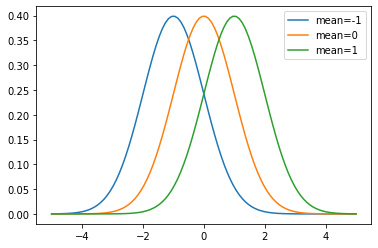

In [11]:
x_d = np.linspace(-5, 5, 100)
pdfs = gauss_pdf(x_d, m=Vec(-1., 0., 1.), sd=1.)
print(pdfs.shape)
for i in range(pdfs.shape[0]):
    plt.plot(x_d, pdfs[i, :], label="mean=%i" % (i - 1))
plt.legend()
plt.show()

Though the above examples are simple in nature, they help to demonstrate a powerful feature: that complex functions can now be efficiently vectorizable into a compact output that is more useful to the user.

## Automatic Parallel Backend

By default `vectorize` has a parallel argument which is set to `False`, but understandably with large numbers of arguments in a potentially slow function, we would like to parallelize calculations on the function, given the key assumption that each set of arguments are independent from one another. 

The decorator has a `parallel` keyword which can be set:

In [12]:
import pandas as pd

In [13]:
@turb.vectorize(parallel=True, return_as="numpy")
def neg_dot(x, z, a, q):
    return x*z - a*q

_X = neg_dot(Vec(*np.arange(10)), 2., -3., Vec(np.linspace(-15, 15, 20)))
_X.shape

(10, 20)

Note in the above example that I **unpacked** the numpy array into the `Param` constructor such that those numbers were in list form.

`Param` will take any object which would normally be represented as a parameter, but it will **NOT** unpack vectors/matrices for you, assuming that you want to pass this as a whole to the function:

In [14]:
try:
    neg_dot(Vec(np.arange(10), 2), 2., -3., Vec(np.arange(-15, 15, 1.5)))
except ValueError as e:
    print(e)

operands could not be broadcast together with shapes (10,) (20,) 


In the above case, the first argument in `Vec` passes the whole numpy array as the first argument to the function, rather than 10 individual numbers.

Just be careful, particular in **product** use cases that what your result is, actually makes sense.

## Null case

In the case where Param is not used, the normal return value is obviously used:

In [15]:
@turb.vectorize
def novec(x, y, z):
    return [x*y -z]

In [16]:
novec(1., 2., 3)

[-1.0]